# Project Notes: 55CNCE I
1D radiative-convective modelling of a H2 atmosphere on 55 Cancri e, with a focus on ground temperature and outgoing radiation. Data from http://www.nature.com/nature/journal/v532/n7598/abs/nature17169.html.
### Collision-Induced Absorption
H2 has significant collision-induced absorption (CIA) in the emission range of a black body at 3000K (55 Cancri e) and 5500K (55 Cancri). Data from http://www.astro.ku.dk/~aborysow/programs/.
<img src="H2_CIA_OLR_3000.svg" alt="H2_CIA_OLR_3000.svg" style="width: 1000px;"/>
* T$_{ref}$ and p$_{ref}$ *do* matter as the reference point for an interpolation, but as long as they match some representative data there's not much difference - the CIA will look strange for T$_{ref}$ and p$_{ref}$ out of the data range
* Averaging the cross-section every 10 points or so doesn't seem to affect the results much, and speeds up the calculations greatly - worth seeing how far to push it

### OLR Testing
Plotting the OLR for various surface pressures and ground temperatures on the dry adiabat, and the incoming radiation around the planet (with albedo depending on surface pressure), shows the expected ground temperature for a given surface pressure and incoming radiation.  
<img src="H2_OLR_ILR.svg" alt="H2_OLR_ILR.svg" style="width: 600px;"/>
* Albedo taken from https://users.physics.ox.ac.uk/~pierrehumbert/papers/H2Worlds.pdf (at low T, ~300K)
* Variable C$_{p}$ from http://webbook.nist.gov/cgi/cbook.cgi?ID=C1333740&Units=SI&Mask=1#Thermo-Gas
* Could use moist adiabat or calculated albedo?

### Radiative-Convective Testing
Plotting T(p) for a range of L and p$_{s}$.  

For L$*$/2 and 10 bar:
<img src="10bar_L2.svg" alt="10bar_L2.svg" style="width: 1000px;"/>
For L$*$/2 and 3 bar:
<img src="3bar_L2.svg" alt="3bar_L2.svg" style="width: 1000px;"/>
For L$*$ and 10 bar:
<img src="10bar_L.svg" alt="10bar_L.svg" style="width: 1000px;"/>
* Lower atmosphere roughly on adiabat, upper almost isothermal - radiating layer is ~1bar
* Atmosphere below 0.01 bar converges very slowly - had to run with very varying time step - is it actually isothermal?
* Plot OLR test with rad-conv profile?

### Outgoing Spectra
The atmosphere could increase the planet's outgoing visible radiation greatly, as it increases the surface temperature and does not absorb visible radiation strongly.  
<img src="outgoing_spectra.svg" alt="outgoing_spectra.svg" style="width: 700px;"/>
* The "Apparent Outgoing Radiation" is the black body spectrum which coincides with the modelled outgoing radiation at 4.5 microns (Demory).
* The "Model" intensity in the visible (above ~14000 cm$^{-1}$) is more than an order of magnitude greater than the "Apparent" intensity

### OLR Widget Demo

In [58]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [59]:
#Hydrogen world summer project script
#Computes semigrey OLR for H2 atmosphere on dry adiabat
#Assumes optically thin stratosphere


from ClimateUtilities import *
import phys
import math


import miniClimtFancyCIABand as rad
from matplotlib.ticker import ScalarFormatter


from ipywidgets import *
from ipywidgets import FloatProgress
from IPython.display import display
import matplotlib.pyplot as plt

import seaborn
seaborn.set_style("whitegrid")
seaborn.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1.2})
seaborn.set_color_codes()

%matplotlib inline

def OLR_Plot(Tg):
    def calcBrightT(I,nu):
        f = nu * 100 * phys.c
        return 1 / ((phys.k / (phys.h * f)) * numpy.log((2 * phys.h * f ** 3 * 100 * math.pi)/(phys.c * I) + 1))

    #-------Set constants-----------
    rad.g = 28. #Set gravity
    rad.LWCutoff = 1e6 #Thermal longwave cutoff; speeds up calc
    rad.Tstellar = 5373.
    rad.Lstellar = 2590 * 1350.
    rad.pref = 1.e3
    rad.Tref = 2600
    rad.bandData = rad.loadContinuumBands('H2_CIA_HOT.dat')
    bands = rad.bandData

    n=35 #n = 200 #(200 used in paper)
    
    ptop = 100.

    #-------------------------------------------------------------------------
    q = numpy.ones(n)
    TgList = numpy.linspace(Tg,3500,1)
    
    points = 5
    ilrList_gen = numpy.logspace(1,0.778,points)
    psList = 1.e5 * numpy.logspace(-0.30102999566,1,points)
    psAlphaList = 1 - (4. * ilrList_gen / 40.)
    ilrList = 0.25 * (1 -  psAlphaList) * rad.Lstellar
    TgListRef = TgList

    i=0

    fig = plt.figure(figsize=(8,5))
    TgIdx=0
    j=0
    for Tg in TgList:
        psIdx=0
        olrList = []
        for ps in psList:
            p = rad.setpLog(ps,ptop,n) #Puts extra resolution in stratosphere.
            T = Tg*(p/ps)**(rad.GHG.Rcp)
            j+=1
            fluxLW,heatLW,fluxBandList = rad.radCompLW(p,T,Tg,q)
            olrList.append(fluxLW[0])

            psIdx += 1
            bar.value = (100 * j/len(psList))
        TgIdx += 1
        i += 1

        plt.loglog(psList/1e5,olrList,'k')
        plt.text(psList[-1]/1e5, 0.9 * olrList[-1], ' {Tg} K'.format(Tg=Tg))



    plt.loglog(psList/1e5,4 * ilrList,'r--', linewidth=2.5,label=r'L = L*')
    #plt.text(psList[3] / 1E5, 1.2 * ilrList[3],r'L = 3.50 MWm$^{-2}$',color='b')

    plt.loglog(psList/1e5,2 * ilrList,'g--', linewidth=2.5,label=r'L = L* / 2')

    plt.loglog(psList/1e5,ilrList,'b--', linewidth=2.5,label=r'L = L* / 4')


    plt.xlabel('Surface Pressure (bar)')
    plt.ylabel('OLR (Wm$^-$$^2$)')
    plt.title('H$_{2}$ atmosphere OLR(p$_{s}$)', fontsize=20, y=1.04)

    axes = plt.gca()

    axes.set_xlim([0.5,10])
    #axes.set_ylim([3e5,5e6])

    axes.xaxis.grid(True, which='major') 
    axes.xaxis.grid(True, which='minor') 
    axes.yaxis.grid(True, which='major') 
    axes.yaxis.grid(True, which='minor')


    legend = axes.legend(loc='lower left',frameon=True,prop={'size':15}) 

    plt.show()

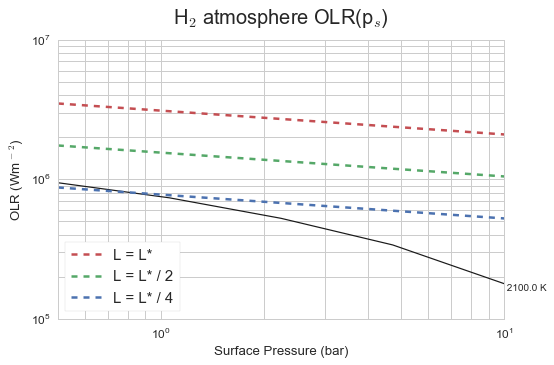

In [60]:
interact(OLR_Plot, Tg=widgets.IntSlider(min=2000,max=3000,step=100,value=2500),__manual=True);
bar = FloatProgress(min=0, max=100,description="Progress")
display(bar)

### RadConv Widget Demo

In [61]:
#Hydrogen world summer project script
#Computes semigrey OLR for H2 atmosphere on dry adiabat
#Assumes optically thin stratosphere


from ClimateUtilities import *
import phys
import math
import matplotlib as mpl
from ipywidgets import *

from IPython import display
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import time

import seaborn
seaborn.set_style("whitegrid")
seaborn.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1.2})
seaborn.set_color_codes()




#Import radiation module
import miniClimtFancyCIABand as rad
#Import rad-conv stepper (with Cp(T) and adiabatic adjustment)
import HWRadConv as RC
#Import general modules

import planets

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


#Import optional seaborn plotting library
import seaborn
seaborn.set_style("whitegrid")
seaborn.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1.2})
seaborn.set_color_codes()


%matplotlib inline


def RadConv(L,Tg,mode):
    #--------------Initializations-------------------------------------------

    #Set initial time step
    dtime = 1.e-4 # 1. # (for CO2 case; gray gas evolves faster)

    #Set number of levels in pressure array
    n = 10

    #Set global constants
    ps = 1.e5 * 10
    rh = 1.e-30#Relative humidity
    rhbdd = 1.e-30
    dt = 24.*3600. * dtime#time step in seconds

    Tg=Tg
    #---Set up pressure array (a global)----
    ptop = 50. #Top pressure in mb (Changed from 1mb in original)
    pstart = .995*ps
    rat = (ptop/pstart)**(1./n)
    logLevels = [pstart*rat**i for i in range(n)]
    logLevels.reverse()
    levels = [ptop + i*(pstart-ptop)/(n-1) for i in range(n)]
    p = numpy.array(logLevels)

    #--------------Other parameters-------------------------------------------
    #Set the gravity and thermodynamic constants
    Rcp = 2./7.
    
    if mode == "Adiabat":
        T = Tg*(p/p[-1])**Rcp
    else:
        T = Tg*numpy.ones(len(p))
    
    rad.tauInf = 5.
    RC.q=numpy.ones(len(p))

    #-------Set constants-----------
    rad.g = 28. #Set gravity
    rad.LWCutoff = 1.e6 #Thermal longwave cutoff; speeds up calc
    rad.Tstellar = 5373.#
    rad.Lstellar = L
    rad.bandData = rad.loadContinuumBands('H2_CIA_HOT.dat')
    rad.pref = 1.e5
    rad.Tref = 2800

    #--------------Model options-------------------------------------------
    #Toggle shortwave absorption
    RC.doStellarAbs = True
    #Toggle variable heat capacity Cp(T)
    RC.doVarRcp = True
    #Toggle surface T balance equation
    RC.doTgBalance = True


    #Brightness T function
    def calcBrightT(I,nu):
        f = nu * 100 * phys.c
        return 1 / ((phys.k / (phys.h * f)) * numpy.log((2 * phys.h * f ** 3 * 100 * math.pi)/(phys.c * I) + 1))


    #---------------------------------------------------------
    #--------------Initializations Done-----------------------
    #--------------Now do the time stepping-------------------
    #---------------------------------------------------------
    for i in range(0,50):
        dt = dt * 0.99
        #oldT=numpy.array(T)
        #if i%50 == 0 & i > 200:
        #     dtime = .5*dtime
        oldT=T[:]
        oldTg=Tg
        Tg,Tad,T,flux,fluxStellar,fluxLW,heat,heatStellar,heatLW,fluxBandList = RC.steps(Tg,T,p,1,dt)
        fig = plt.figure(figsize=(16,5))
        gs1 = gridspec.GridSpec(1,2)
        ax_list = [fig.add_subplot(ss) for ss in gs1]


        #Plot local adiabats for comparison
        #for j in range(400,8000,800):
        #    Tad = j*(p/p[-1])**Rcp
        #    ax_list[0].plot(Tad,p/1e5,'0.8')
        #    ax_list[1].semilogy(Tad,p/1e5,'0.8')

        ax_list[0].plot(T,p/1e5,'k')
        #line.set_ydata(T)
        ax_list[0].invert_yaxis()
        ax_list[0].set_xlim([0,4000])
        #ax_list[0].set_ylim([0.1,1000])
        ax_list[0].set_xlabel('Temperature (K)')
        ax_list[0].set_ylabel('Pressure (bar)')
        ax_list[0].set_title('Temperature Profile', fontsize=20, y=1.04)

        ax_list[1].semilogy(T,p/1e5,'k')
        ax_list[1].set_xlim([0,4000])
        ax_list[1].set_ylim([0.001,ps/1e5])
        ax_list[1].invert_yaxis()    
        ax_list[1].set_xlabel('Temperature (K)')
        ax_list[1].set_ylabel('Pressure (bar)')
        ax_list[1].set_title('Semilog Temperature Profile', fontsize=20, y=1.04)
        #plt.show()

        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.1)

    


In [62]:
interact(RadConv, L=widgets.IntSlider(min=1350.*2590.,max=1350.*2590.*4.,step=1000,value=1350.*2590.*2.),Tg=widgets.IntSlider(min=2000,max=3000.,step=100,value=2500),mode=('Adiabat','Isotherm'),__manual=True);